In [41]:
#导入相关库
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils

In [2]:
#参数定义
#dataset = "FashionMNIST" #选择所使用的数据集"MNIST"or"FashionMNIST"
dataset = "MNIST"
Net = "LeNet5" #选择所使用的网络"LeNet5"or "LinearNet"
# Net = "LinearNet" #选择所使用的网络"LeNet5"or "LinearNet"
batch_size = 64 #定义批处理大小
lr=0.01 #设置learning rate学习率
epochs = 8 #指定训练迭代次数
save_path = "./" #模型保存路径
Early_Stopping = 0 #选择是否使用Early Stopping训练模式，训练时根据精度的变化率来控制训练迭代代数

In [3]:
#下载数据集
if dataset=="MNIST":
    # 从torchvision下载训练集.
    training_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # #从torchvision下载测试集.
    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )
    # 若是数字数据集则设置成下述类别
    classes = [ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
else:
    # 从torchvision下载训练集.
    training_data = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # #从torchvision下载测试集.
    test_data = datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )
    # 若是服饰数据集则设置成下述类别
    classes = [ "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal","Shirt", "Sneaker", "Bag", "Ankle boot"]

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


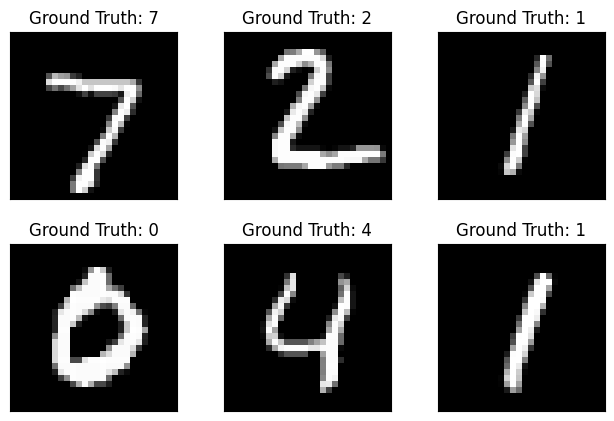

In [4]:
# 创建数据加载器.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

#观察数据样本
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    fig = plt.figure()
    # 对部分数据进行显示
    for i in range(6):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      plt.imshow(X[i][0], cmap='gray', interpolation='none')
      plt.title("Ground Truth: {}".format(classes[int(y[i])]))
      plt.xticks([])
      plt.yticks([])
    plt.show()
    break

In [5]:
# 自动选择cpu或gpu用于训练.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
'''
    残差块定义：
    参数：
        in_channels：输入特征的通道数
        out_channels: 输出特征的通道数
        stride: 步长
        downsample: 如果输入输出不匹配，用于下采样的模块
'''

class ResidualBlock(nn.Module):  
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):  
        super(ResidualBlock, self).__init__()  
            
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) 
        
        # 进行批量归一化
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 激活函数
        self.relu = nn.ReLU(inplace=True)  
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn2 = nn.BatchNorm2d(out_channels)  
          
        # 短路连接（如果输入输出通道数或特征图大小不同，需要进行下采样）  
        self.downsample = downsample  
          
    def forward(self, x):  
        residual = x
          
        # 主路径
#         print(x.shape)
        out = self.conv1(x)  
        out = self.bn1(out)
        out = self.relu(out)  
        out = self.conv2(out)  
        out = self.bn2(out)  
          
        # 短路连接  
        if self.downsample is not None:  
            residual = self.downsample(x)  
          
        # 残差连接  
        # 将主路径和短路连接的结果相加
        out += residual  
        out = self.relu(out)  
        
        # 返回经过残差处理后的特征图
        return out

In [7]:
#定义模型

if Net == "LinearNet":
    # 普通神经网络
    class LinearNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(28*28, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 10)
            )

        def forward(self, x):
            x = self.flatten(x)
            logits = self.linear_relu_stack(x)
            return logits

    model = LinearNet().to(device)
    
else:
    class CNN_1(nn.Module):
        def __init__(self):
            super(CNN_1, self).__init__()
            self.conv1 = nn.Conv2d(
                    ## 卷积核大小为羽3，输入通道为__，输出通道为13，步长为1;
                    ## paddingHzero padding
                    ##要求经过conv1的输出空间维度与输入的空间维度相同
                    in_channels = 1,
                    out_channels = 13,
                    kernel_size = 3,
                    stride= 1,
                    padding= 1,
                )
            ##激活函数+最大池化
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            
            self.conv2d = nn.Sequential(
            ## 1. 卷积核大小为3*3，输入通道为10，输出通道为10，padding 方法为same，padding大小为？？？步长为??
            ## 2.自行选择激活函数
            ## 3. 池化
                nn.Conv2d(in_channels=13,
                         out_channels=10,
                         kernel_size=3,
                         stride=1,
                         padding=1),
                self.relu,
                self.pool
            )
            ## 添加残差连接模块
            #############残差模块设计部分################
            self.res_block = ResidualBlock(10, 10)

            ############################################
            self.conv3 = nn.Sequential(
                ##自行设计卷积模块
                nn.Conv2d(in_channels=10,
                         out_channels=29,
                         kernel_size=3,
                         stride=1,
                         padding=1),
                self.relu,
                self.pool
            )
            self.out1 = nn.Linear(3*3*29, 10, bias = True)
            ## 在下方添加Dropout以及其他代码
            self.dropout = nn.Dropout(p=0.5)

        def forward(self, x):
            ## 请将余下代码补充完整
            # 卷积后图像大小保持不变
            # (64,1,28,28)
            x = self.relu(self.conv1(x))
            x = self.pool(x)
            # (64,13,14,14)
            x = self.conv2d(x)
            # (64,10,7,7)
            x = self.res_block(x)
            # (64,10,7,7)
            x = self.conv3(x)
            # (64,10,3,3)
            
            x = x.view(x.size(0), -1)
            x = self.dropout(x)
            x = self.out1(x)
            
            return x
            

    model = CNN_1().to(device)


print(model)

CNN_1(
  (conv1): Conv2d(1, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d): Sequential(
    (0): Conv2d(13, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res_block): ResidualBlock(
    (conv1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(10, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [10]:
#为了训练模型，我们需要一个损失函数和一个优化器
loss_fn = nn.CrossEntropyLoss()#定义损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)#定义优化器

#在单个训练循环中，模型对训练数据集进行预测（分批提供给它），并反向传播预测误差以调整模型的参数
def train(dataloader, model, loss_fn, optimizer, flag=0):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        tensor_new = y
        if flag == 1:
            tensor_new = torch.zeros(y.shape[0], 10)
            for i in range(len(y)):
                tensor_new[i,y[i]] = 1
        # Compute prediction error
        tensor_new = tensor_new.to(device)
        pred = model(X)
#         print(pred.shape)
#         print(tensor_new.shape)
        loss = loss_fn(pred, tensor_new)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

#对照测试数据集检查模型的性能，以确保它正在学习
def test(dataloader, model, loss_fn, flag=0):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            tensor_new = y
            if flag == 1:
                tensor_new = torch.zeros(y.shape[0], 10)
                for i in range(len(y)):
                    tensor_new[i,y[i]] = 1
            tensor_new = tensor_new.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, tensor_new).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss
    
#实现Early Stopping训练
class EarlyStopping:
    def __init__(self, save_path, patience=2, verbose=False, delta=0.03):
        """
        Args:
            save_path : 模型保存路径
            patience (int): 设置将连续几次训练迭代纳入Early Stopping考评
            verbose (bool): 如果是 "True"，则为每次验证损失的优化值打印一条信息
            delta (float): 前后两次训练迭代的最小变化阈值，小于该阈值则认为模型优化幅度有限，将该次迭代计入patience，
                           数量达到patience则提前停止训练。
        """
        self.save_path = save_path
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        # 尚未找到最佳的验证分数
        if self.best_score is None:
            # 将当前的分数作为最佳分数
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        # 如果分数没有得到明显改善
        elif score < self.best_score + self.delta:
            # 计时器加1操作
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            # 如果超出一定时间，说明达到最优，则进行保存
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # 如果得到明显改善，说明还未达到最优，则进行存储，同时继续进行查找
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''当验证损失降低时，保存模型'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        path = os.path.join(self.save_path, 'best_network.pth')
        torch.save(model.state_dict(), path)	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss


In [36]:
#训练过程是在所定义的几个迭代上进行的。在每次迭代，模型学习参数以做出更好的预测。我们在每次迭代打印模型的准确性和损失；我们希望看到精度随着迭代次数的增加而增加，而损失随着迭代次数的减少而减少
early_stopping = EarlyStopping(save_path)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    if Early_Stopping:
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break #跳出迭代，结束训练
print("Done!")

Epoch 1
-------------------------------
loss: 0.043084  [   64/60000]
loss: 0.022173  [ 6464/60000]
loss: 0.055733  [12864/60000]
loss: 0.013116  [19264/60000]
loss: 0.076859  [25664/60000]
loss: 0.042566  [32064/60000]
loss: 0.011415  [38464/60000]
loss: 0.023089  [44864/60000]
loss: 0.180605  [51264/60000]
loss: 0.014221  [57664/60000]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.037902 

Epoch 2
-------------------------------
loss: 0.050694  [   64/60000]
loss: 0.059616  [ 6464/60000]
loss: 0.045975  [12864/60000]
loss: 0.063846  [19264/60000]
loss: 0.137655  [25664/60000]
loss: 0.105314  [32064/60000]
loss: 0.012601  [38464/60000]
loss: 0.012116  [44864/60000]
loss: 0.101711  [51264/60000]
loss: 0.015794  [57664/60000]
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.048066 

Epoch 3
-------------------------------
loss: 0.009560  [   64/60000]
loss: 0.048139  [ 6464/60000]
loss: 0.039090  [12864/60000]
loss: 0.018426  [19264/60000]
loss: 0.115241  [25664/60000]
loss: 0.011705  [32064/600

In [37]:
#保存模型的一种常见方法是序列化内部状态字典(包含模型参数)
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [38]:
#加载模型的过程包括重新创建模型结构并将状态字典加载到其中。
model = LinearNet().to(device) if Net == "LinearNet" else CNN_1().to(device)
model.load_state_dict(torch.load("model.pth"))

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.unsqueeze_(0).to(device)
#     x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "7", Actual: "7"


In [14]:
# 不同lr的影响
lrList = [0.001,0.01,0.1,1,10]
lr_loss = []

for lr in lrList:
    model = CNN_1().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)#定义优化器
    print(f"lr: {lr}\n-------------------------------------------------------------")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test_loss = test(test_dataloader, model, loss_fn)
    lr_loss.append(test_loss)
    print("Done!")



lr: 0.001
-------------------------------------------------------------
Epoch 1
-------------------------------
loss: 2.306097  [   64/60000]
loss: 2.247044  [ 6464/60000]
loss: 2.303789  [12864/60000]
loss: 2.194507  [19264/60000]
loss: 2.133592  [25664/60000]
loss: 2.135555  [32064/60000]
loss: 1.918354  [38464/60000]
loss: 2.004908  [44864/60000]
loss: 1.921607  [51264/60000]
loss: 1.834036  [57664/60000]
Test Error: 
 Accuracy: 67.9%, Avg loss: 1.675255 

Epoch 2
-------------------------------
loss: 1.750150  [   64/60000]
loss: 1.572982  [ 6464/60000]
loss: 1.565745  [12864/60000]
loss: 1.518401  [19264/60000]
loss: 1.502563  [25664/60000]
loss: 1.258546  [32064/60000]
loss: 1.134379  [38464/60000]
loss: 1.146959  [44864/60000]
loss: 1.194839  [51264/60000]
loss: 0.989342  [57664/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.807195 

Epoch 3
-------------------------------
loss: 0.966556  [   64/60000]
loss: 0.912614  [ 6464/60000]
loss: 0.858950  [12864/60000]
loss: 0.802690

loss: 0.083470  [19264/60000]
loss: 0.024124  [25664/60000]
loss: 0.022186  [32064/60000]
loss: 0.071796  [38464/60000]
loss: 0.090214  [44864/60000]
loss: 0.321476  [51264/60000]
loss: 0.028896  [57664/60000]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.036939 

Epoch 6
-------------------------------
loss: 0.015509  [   64/60000]
loss: 0.026405  [ 6464/60000]
loss: 0.034581  [12864/60000]
loss: 0.141381  [19264/60000]
loss: 0.038550  [25664/60000]
loss: 0.013055  [32064/60000]
loss: 0.056221  [38464/60000]
loss: 0.026597  [44864/60000]
loss: 0.252121  [51264/60000]
loss: 0.037837  [57664/60000]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.041346 

Epoch 7
-------------------------------
loss: 0.015122  [   64/60000]
loss: 0.163332  [ 6464/60000]
loss: 0.024341  [12864/60000]
loss: 0.132303  [19264/60000]
loss: 0.018091  [25664/60000]
loss: 0.021770  [32064/60000]
loss: 0.106586  [38464/60000]
loss: 0.053721  [44864/60000]
loss: 0.087225  [51264/60000]
loss: 0.035212  [57664/60000]
Test E

In [15]:
# 不同batchsize的影响
batchSizeList = [16, 32, 64, 128, 256]
batch_loss = []

for batch in batchSizeList:
    model = CNN_1().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)#定义优化器
    train_dataloader = DataLoader(training_data, batch_size=batch)
    test_dataloader = DataLoader(test_data, batch_size=batch)
    print(f"barch: {batch}\n-------------------------------------------------------------")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test_loss = test(test_dataloader, model, loss_fn)
    batch_loss.append(test_loss)
    print("Done!")

barch: 16
-------------------------------------------------------------
Epoch 1
-------------------------------
loss: 2.458938  [   16/60000]
loss: 2.305448  [ 1616/60000]
loss: 2.234544  [ 3216/60000]
loss: 2.195567  [ 4816/60000]
loss: 2.107365  [ 6416/60000]
loss: 2.155208  [ 8016/60000]
loss: 2.068627  [ 9616/60000]
loss: 2.137973  [11216/60000]
loss: 1.860306  [12816/60000]
loss: 1.736449  [14416/60000]
loss: 1.710513  [16016/60000]
loss: 1.821875  [17616/60000]
loss: 1.737623  [19216/60000]
loss: 1.396893  [20816/60000]
loss: 1.355071  [22416/60000]
loss: 1.126924  [24016/60000]
loss: 1.167807  [25616/60000]
loss: 0.999632  [27216/60000]
loss: 0.864241  [28816/60000]
loss: 1.063081  [30416/60000]
loss: 0.866053  [32016/60000]
loss: 1.104217  [33616/60000]
loss: 0.618154  [35216/60000]
loss: 1.381436  [36816/60000]
loss: 0.812713  [38416/60000]
loss: 0.874165  [40016/60000]
loss: 0.882425  [41616/60000]
loss: 0.767802  [43216/60000]
loss: 0.519121  [44816/60000]
loss: 0.702675  [4

loss: 0.091088  [36816/60000]
loss: 0.131799  [38416/60000]
loss: 0.282098  [40016/60000]
loss: 0.251074  [41616/60000]
loss: 0.122868  [43216/60000]
loss: 0.081682  [44816/60000]
loss: 0.301016  [46416/60000]
loss: 0.156486  [48016/60000]
loss: 0.033435  [49616/60000]
loss: 0.053159  [51216/60000]
loss: 0.562637  [52816/60000]
loss: 0.040219  [54416/60000]
loss: 0.125971  [56016/60000]
loss: 0.182416  [57616/60000]
loss: 0.023976  [59216/60000]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.067584 

Epoch 8
-------------------------------
loss: 0.007233  [   16/60000]
loss: 0.411373  [ 1616/60000]
loss: 0.040364  [ 3216/60000]
loss: 0.038198  [ 4816/60000]
loss: 0.023284  [ 6416/60000]
loss: 0.374255  [ 8016/60000]
loss: 0.079322  [ 9616/60000]
loss: 0.327499  [11216/60000]
loss: 0.024620  [12816/60000]
loss: 0.078672  [14416/60000]
loss: 0.022489  [16016/60000]
loss: 0.052796  [17616/60000]
loss: 0.085221  [19216/60000]
loss: 0.047136  [20816/60000]
loss: 0.065047  [22416/60000]
loss: 0.

loss: 0.764141  [44864/60000]
loss: 0.691098  [51264/60000]
loss: 0.805788  [57664/60000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.499780 

Epoch 4
-------------------------------
loss: 0.722129  [   64/60000]
loss: 0.621091  [ 6464/60000]
loss: 0.573750  [12864/60000]
loss: 0.674524  [19264/60000]
loss: 0.609381  [25664/60000]
loss: 0.513650  [32064/60000]
loss: 0.406509  [38464/60000]
loss: 0.674784  [44864/60000]
loss: 0.458065  [51264/60000]
loss: 0.459487  [57664/60000]
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.347665 

Epoch 5
-------------------------------
loss: 0.457394  [   64/60000]
loss: 0.387700  [ 6464/60000]
loss: 0.375642  [12864/60000]
loss: 0.530944  [19264/60000]
loss: 0.379961  [25664/60000]
loss: 0.436235  [32064/60000]
loss: 0.331166  [38464/60000]
loss: 0.489751  [44864/60000]
loss: 0.391076  [51264/60000]
loss: 0.437654  [57664/60000]
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.269852 

Epoch 6
-------------------------------
loss: 0.417112  [   64/60000]
loss

In [17]:
# 不同损失函数的影响
loss_fnList = [nn.MSELoss(), nn.CrossEntropyLoss()]
fn_loss = []
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for loss_fn in loss_fnList:
    model = CNN_1().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)#定义优化器
    flag = 0
    if isinstance(loss_fn, nn.MSELoss):
        flag = 1
    else:
        flag = 0
    print(f"loss: {loss_fn}\n-------------------------------------------------------------")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer, flag = flag)
        test_loss = test(test_dataloader, model, loss_fn, flag=flag)
    fn_loss.append(test_loss)
    print("Done!")

loss: MSELoss()
-------------------------------------------------------------
Epoch 1
-------------------------------
loss: 0.314305  [   64/60000]
loss: 0.186617  [ 6464/60000]
loss: 0.169233  [12864/60000]
loss: 0.141465  [19264/60000]
loss: 0.137217  [25664/60000]
loss: 0.134567  [32064/60000]
loss: 0.133814  [38464/60000]
loss: 0.131038  [44864/60000]
loss: 0.116091  [51264/60000]
loss: 0.106964  [57664/60000]
Test Error: 
 Accuracy: 26.5%, Avg loss: 0.086673 

Epoch 2
-------------------------------
loss: 0.119623  [   64/60000]
loss: 0.112449  [ 6464/60000]
loss: 0.111531  [12864/60000]
loss: 0.105565  [19264/60000]
loss: 0.102908  [25664/60000]
loss: 0.106589  [32064/60000]
loss: 0.102198  [38464/60000]
loss: 0.103200  [44864/60000]
loss: 0.107143  [51264/60000]
loss: 0.106082  [57664/60000]
Test Error: 
 Accuracy: 37.4%, Avg loss: 0.082653 

Epoch 3
-------------------------------
loss: 0.099312  [   64/60000]
loss: 0.102246  [ 6464/60000]
loss: 0.091033  [12864/60000]
loss: 0.

In [18]:
# 不同优化器的影响

loss_fn = nn.CrossEntropyLoss()
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
optim_loss = []
for i in range(2):
    model = CNN_1().to(device)
    # 进行优化器选择
    if i == 0:
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)#定义优化器
    if i == 1:
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    print(f"loss: {loss_fn}\n-------------------------------------------------------------")
    # 进行训练
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test_loss = test(test_dataloader, model, loss_fn)
    optim_loss.append(test_loss)
    print("Done!")

loss: CrossEntropyLoss()
-------------------------------------------------------------
Epoch 1
-------------------------------
loss: 2.462541  [   64/60000]
loss: 2.360496  [ 6464/60000]
loss: 2.186509  [12864/60000]
loss: 2.241232  [19264/60000]
loss: 2.211177  [25664/60000]
loss: 2.207590  [32064/60000]
loss: 1.966873  [38464/60000]
loss: 2.038838  [44864/60000]
loss: 2.008360  [51264/60000]
loss: 1.883597  [57664/60000]
Test Error: 
 Accuracy: 67.7%, Avg loss: 1.734086 

Epoch 2
-------------------------------
loss: 1.834189  [   64/60000]
loss: 1.742633  [ 6464/60000]
loss: 1.538739  [12864/60000]
loss: 1.673459  [19264/60000]
loss: 1.570899  [25664/60000]
loss: 1.481258  [32064/60000]
loss: 1.243336  [38464/60000]
loss: 1.284279  [44864/60000]
loss: 1.288906  [51264/60000]
loss: 1.235968  [57664/60000]
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.951200 

Epoch 3
-------------------------------
loss: 1.139205  [   64/60000]
loss: 1.072392  [ 6464/60000]
loss: 0.902140  [12864/60000]

Text(0, 0.5, 'Loss')

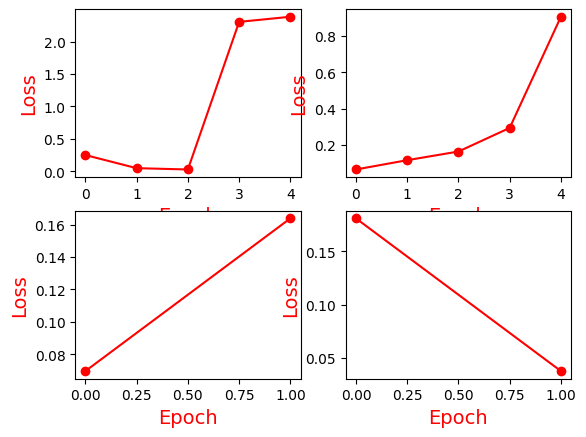

In [30]:
# 画图操作
# 同时进行存储
plt.subplot(221)
Listlr = list(range(len(lrList)))
plt.plot(Listlr, lr_loss, color='r', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='r')
plt.ylabel('Loss', fontsize=14, color='r')
plt.subplot(222)
Listbatch = list(range(len(batchSizeList)))
plt.plot(Listbatch, batch_loss, color='r', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='r')
plt.ylabel('Loss', fontsize=14, color='r')
plt.subplot(223)
ListLoss = list(range(len(loss_fnList)))
plt.plot(ListLoss, fn_loss, color='r', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='r')
plt.ylabel('Loss', fontsize=14, color='r')

plt.subplot(224)
ListOptim = list(range(2))
plt.plot(ListOptim, optim_loss, color='r', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='r')
plt.ylabel('Loss', fontsize=14, color='r')


In [43]:
# 显示卷积核
# 卷积核可视化
# 设置存储路径
baseDir = os.path.dirname("./")
log_dir = os.path.join(baseDir, "result")
writer = SummaryWriter(log_dir=log_dir, filename_suffix="_kernel")

# 设置权重文件的路径
state_dict_path = "./model.pth"
#判断路径是否存在
if os.path.exists(state_dict_path):
    # 如果权重文件存在，则把他加载进来
    print("model path exists")
    visual_model = CNN_1().to(device)
    state_dict = torch.load(state_dict_path)
    visual_model.load_state_dict(state_dict)
else:
    print("model path dosen exist")
    

# 想要访问的起始网络层的序号
kernel_num = -1

# 最多可视化到的网络层序号
vis_max = 1

# 遍历网络层
for sub_module in visual_model.modules():
    # 判断是否为卷积层
    if isinstance(sub_module, nn.Conv2d):
        kernel_num += 1
        # 判断是否超过要可视化的网络层序号
        if kernel_num > vis_max:
            break
        kernels = sub_module.weight
        # 得到输出通道数，输入通道数，核宽，核高
        c_out, c_int, k_w, k_h = tuple(kernels.shape)
        print(kernels.shape)
        # 对c_out单独可视化
        for o_idx in range(c_out):
            kernel_idx = kernels[o_idx, :, :, :].unsqueeze(1)  # make_grid需要 BCHW，这里拓展C维度
            
            kernel_grid = vutils.make_grid(kernel_idx, normalize=True, scale_each=True, nrow=c_int)
            writer.add_image('{}_Convlayer_split_in_channel'.format(kernel_num), kernel_grid)
                
        # 对64个卷积核直接进行可视化
        kernel_all = kernels.view(-1, 1, k_h, k_w)  # b，3, h, w
        kernel_grid = vutils.make_grid(kernel_all, normalize=True, scale_each=True, nrow=8)  # c, h, w
        writer.add_image('{}_all'.format(kernel_num), kernel_grid, global_step=322)
        print("{}_convlayer shape:{}".format(kernel_num, tuple(kernels.shape)))
writer.close()

model path exists
torch.Size([13, 1, 3, 3])
0_convlayer shape:(13, 1, 3, 3)
torch.Size([10, 13, 3, 3])
1_convlayer shape:(10, 13, 3, 3)
